In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import xarray as xr

from ooi_data_explorations.common import get_annotations, load_gc_thredds, add_annotation_qc_flags
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.uncabled.process_pco2a import pco2a_datalogger
from ooi_data_explorations.uncabled.process_phsen import phsen_datalogger, phsen_instrument

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
print(os.environ.get('refdes'))
print(os.environ.get('startTime'))
print(os.environ.get('endTime'))
print(os.environ.get('stream'))
print(os.environ.get('method'))

CP10CNSM-RID27-07-PLIMSA000
2024-05-01T00:00:00+00:00
2024-10-31T23:59:59.999000+00:00
pco2a_a_dcl_instrument_water_recovered
recovered_host


In [4]:
print(os.environ.get('JUPYTER_IMAGE'))

ciw-gitlab-registry.intra.oceanobservatories.org:5050/kubernetes/jupyterhub_images/datascience-xtra:2025-04-02-2352


In [2]:
for var in os.environ.items():
    print(var)

('SHELL', '/bin/bash')
('KUBERNETES_SERVICE_PORT_HTTPS', '443')
('JUPYTERHUB_ADMIN_ACCESS', '1')
('KUBERNETES_SERVICE_PORT', '443')
('PROXY_API_SERVICE_HOST', '10.152.183.146')
('CONDA_EXE', '/opt/conda/bin/conda')
('JUPYTERHUB_SERVICE_URL', 'http://0.0.0.0:8888/user/joffrey.peters@whoi.edu/')
('HOSTNAME', 'jupyter-joffrey-2epeters-40whoi-2eedu')
('LANGUAGE', 'C.UTF-8')
('JUPYTERHUB_API_TOKEN', '2bfaebd924bb400b91bc671ab03241ce')
('_START_SH_EXECUTED', '1')
('PROXY_API_SERVICE_PORT', '8001')
('JUPYTERHUB_BASE_URL', '/')
('NB_UID', '1000')
('JULIA_PKGDIR', '/opt/julia')
('PROXY_PUBLIC_PORT_80_TCP', 'tcp://10.152.183.189:80')
('PROXY_PUBLIC_PORT', 'tcp://10.152.183.189:443')
('XML_CATALOG_FILES', 'file:///opt/conda/etc/xml/catalog file:///etc/xml/catalog')
('PROXY_PUBLIC_SERVICE_PORT_HTTP', '80')
('PWD', '/home/jovyan')
('GSETTINGS_SCHEMA_DIR', '/opt/conda/share/glib-2.0/schemas')
('CONDA_PREFIX', '/opt/conda')
('MEM_GUARANTEE', '1073741824')
('GSETTINGS_SCHEMA_DIR_CONDA_BACKUP', '')
('J

In [2]:
from ooi_data_explorations.qartod.climatology import Climatology
clm = Climatology()

In [6]:
def merge_pco2a(site, node, sensor):
    """
    Download the PCO2A water measurement data files from the OOI Gold Copy 
    THREDDS server, combine the data from the two different data delivery 
    methods, and median average the data into daily averages.
    """
    # set the stream names and the regex tag to use to select the data files of interest
    tstream = 'pco2a_a_dcl_instrument_water'
    rstream = 'pco2a_a_dcl_instrument_water_recovered'
    tag = '.*PCO2A.*water.*\\.nc$'

    # download annotations associated with this site
    annotations = get_annotations(site, node, sensor)

    # download the telemetered data and re-process it to create a more useful and coherent data set
    print('### -- Downloading the telemetered data')
    telem = load_gc_thredds(site, node, sensor, 'telemetered', tstream, tag)
    telem = pco2a_datalogger(telem)
    
    # download the recovered host data and re-process it to create a more useful and coherent data set
    print('### -- Downloading the recovered_host data')
    rhost = load_gc_thredds(site, node, sensor, 'recovered_host', rstream, tag)
    rhost = pco2a_datalogger(rhost)

    # create a roll-up annotation flag
    telem = add_annotation_qc_flags(telem, annotations)
    rhost = add_annotation_qc_flags(rhost, annotations)
    
    # clean-up the data, removing values that are marked as suspect or fail in the annotations
    telem = telem.where((telem.partial_pressure_co2_ssw_annotations_qc_results < 3) & 
                        (telem.rollup_annotations_qc_results < 3))
    rhost = rhost.where((rhost.partial_pressure_co2_ssw_annotations_qc_results < 3) & 
                        (rhost.rollup_annotations_qc_results < 3))

    # combine the two datasets into a single, merged time series resampled to daily median averages
    merged = combine_datasets(telem, rhost, None, 1440)
    return merged

In [7]:
def merge_phsen(site, node, sensor):
    """
    Download the PHSEN data files from the OOI Gold Copy THREDDS server, combine 
    the data from the three different data delivery methods, and median average 
    the data into daily averages.
    """
    # download annotations associated with this site
    annotations = get_annotations(site, node, sensor)

    tag = '.*PHSEN.*\\.nc$'
    print('### -- Downloading the telemetered data')
    telem = load_gc_thredds(site, node, sensor, 'telemetered', 'phsen_abcdef_dcl_instrument', tag)
    telem = phsen_datalogger(telem)
    
    # download the recovered host data and re-process it to create a more useful and coherent data set
    print('### -- Downloading the recovered_host data')
    rhost = load_gc_thredds(site, node, sensor, 'recovered_host', 'phsen_abcdef_dcl_instrument_recovered', tag)
    rhost = phsen_datalogger(rhost)

    # download the recovered instrument data and re-process it to create a more useful and coherent data set
    print('### -- Downloading the recovered_inst data')
    rinst = load_gc_thredds(site, node, sensor, 'recovered_inst', 'phsen_abcdef_instrument', tag)
    rinst = phsen_instrument(rinst)
    
    # create a roll-up annotation flag
    telem = add_annotation_qc_flags(telem, annotations)
    rhost = add_annotation_qc_flags(rhost, annotations)
    rinst = add_annotation_qc_flags(rinst, annotations)

    # clean-up the data, removing values that fail the pH quality checks or were marked as fail in the annotations
    telem = telem.where((telem.seawater_ph_quality_flag != 4) & (telem.rollup_annotations_qc_results != 4))
    rhost = rhost.where((rhost.seawater_ph_quality_flag != 4) & (rhost.rollup_annotations_qc_results != 4))
    rinst = rinst.where((rinst.seawater_ph_quality_flag != 4) & (rinst.rollup_annotations_qc_results != 4))
    
    # combine the three datasets into a single, merged time series resampled to daily median averages
    merged = combine_datasets(telem, rhost, rinst, 1440)
    return merged

In [13]:
# download the pco2a and phsen data from the 4 Endurance array Coastal Surface Moorings, 
# merging the data from the different data delivery methods and saving the results to disk
# for further analysis.
sites = ['CE02SHSM', 'CE04OSSM', 'CE07SHSM', 'CE09OSSM']
pco2a = []
phsen = []
for num, site in enumerate(sites):
    # save the PCO2A data to local files in the home directory under ooidata
    pco2_path = os.path.join(os.path.expanduser('~'), 'ooidata/%s/buoy/pco2a' % site.lower())
    if not os.path.exists(pco2_path):
        os.makedirs(pco2_path)
    
    pco2a_file = os.path.join(pco2_path, '%s.pco2a.merged.nc' % site.lower())

    # save the PHSEN data to local files in the home directory under ooidata
    ph_path = os.path.join(os.path.expanduser('~'), 'ooidata/%s/nsif/phsen' % site.lower())
    if not os.path.exists(ph_path):
        os.makedirs(ph_path)

    phsen_file = os.path.join(ph_path, '%s.phsen.merged.nc' % site.lower())

    # download the data, or ...
    print('### Downloading the PCO2A data from %s ###' % site)
    pco2a.append(merge_pco2a(site, 'SBD12', '04-PCO2AA000'))
    pco2a[num].to_netcdf(pco2a_file, mode='w', format='NETCDF4', engine='h5netcdf')
    time.sleep(10)  # pause, the THREDDS server doesn't like getting hammered
    
    print('### Downloading the PHSEN data from %s ###' % site)
    phsen.append(merge_phsen(site, 'RID26', '06-PHSEND000'))
    phsen[num].to_netcdf(phsen_file, mode='w', format='NETCDF4', engine='h5netcdf')
    time.sleep(10)  # pause, the THREDDS server doesn't like getting hammered

    # ... load the already downloaded data
    # pco2a.append(xr.load_dataset(pco2a_file))
    # phsen.append(xr.load_dataset(phsen_file))    

### Downloading the PCO2A data from CE02SHSM ###
### -- Downloading the telemetered data
### -- Downloading the recovered_host data
### Downloading the PHSEN data from CE02SHSM ###
### -- Downloading the telemetered data
### -- Downloading the recovered_host data
### -- Downloading the recovered_inst data
### Downloading the PCO2A data from CE04OSSM ###
### -- Downloading the telemetered data
### -- Downloading the recovered_host data
### Downloading the PHSEN data from CE04OSSM ###
### -- Downloading the telemetered data
### -- Downloading the recovered_host data
### -- Downloading the recovered_inst data
### Downloading the PCO2A data from CE07SHSM ###
### -- Downloading the telemetered data
### -- Downloading the recovered_host data
### Downloading the PHSEN data from CE07SHSM ###
### -- Downloading the telemetered data
### -- Downloading the recovered_host data
### -- Downloading the recovered_inst data
### Downloading the PCO2A data from CE09OSSM ###
### -- Downloading the telemet

In [14]:
# setup arrays with the fugacity and pH data from Fassbender et al 2018
buoy_fco2 = np.array([
    [1, 341, 24, 398, 368, 29, 1485],
    [2, 358, 30, 221, 343, 38, 1347],
    [3, 415, 74, 245, 322, 34, 1295],
    [4, 245, 41, 279, 277, 36, 1199],
    [5, 204, 33, 484, 279, 41, 1158],
    [6, 212, 48, 1080, 260, 51, 1244],
    [7, 258, 68, 1461, 281, 57, 1715],
    [8, 283, 58, 1648, 276, 52, 1812],
    [9, 325, 45, 1346, 316, 51, 1619],
    [10, 342, 25, 1028, 330, 47, 1753],
    [11, 358, 40, 645, 364, 34, 1506],
    [12, 349, 26, 495, 371, 21, 1484]
])

region_fco2 = np.array([
    [1, 358, 57, 373, 120, 361, 163],
    [2, 385, 65, 341, 19, 363, 446],
    [3, 356, 170, 311, 98, 343, 250],
    [4, 264, 7, 277, 23, 320, 66],
    [5, 337, 34, 287, 135, 320, 364],
    [6, 288, 1700, 287, 3456, 322, 2791],
    [7, 282, 6969, 257, 1545, 340, 4026],
    [8, 275, 6301, 275, 3614, 330, 1876],
    [9, 285, 750, 323, 719, 344, 504],
    [10, 359, 5, 350, 24, 344, 88],
    [11, 351, 13, 340, 46, 349, 109],
    [12, np.nan, 0, np.nan, 0, 357, 29],
])

buoy_ph = np.array([
    [1, 8.07, 0.03, 398, 8.06, 0.03, 1485],
    [2, 8.08, 0.03, 222, 8.08, 0.04, 1347],
    [3, 8.02, 0.06, 248, 8.11, 0.04, 1295],
    [4, 8.22, 0.06, 279, 8.17, 0.05, 1199],
    [5, 8.27, 0.06, 495, 8.17, 0.05, 1158],
    [6, 8.26, 0.09, 1117, 8.2, 0.07, 1244],
    [7, 8.21, 0.09, 1461, 8.17, 0.07, 1715],
    [8, 8.17, 0.08, 1648, 8.18, 0.07, 1812],
    [9, 8.11, 0.07, 1547, 8.13, 0.06, 1619],
    [10, 8.09, 0.03, 1172, 8.11, 0.06, 1753],
    [11, 8.06, 0.05, 646, 8.07, 0.04, 1506],
    [12, 8.07, 0.03, 496, 8.06, 0.02, 1484],  
])

region_ph = np.array([
    [1, 8.07, 57, 8.06, 120, 8.07, 163],
    [2, 8.05, 65, 8.09, 19, 8.07, 446],
    [3, 8.07, 170, 8.12, 98, 8.09, 250],
    [4, 8.19, 7, 8.16, 23, 8.12, 66],
    [5, 8.1, 34, 8.14, 135, 8.12, 358],
    [6, 8.15, 1700, 8.15, 3456, 8.11, 2791],
    [7, 8.16, 6969, 8.2, 1545, 8.09, 4024],
    [8, 8.14, 5585, 8.16, 3059, 8.1, 1770],
    [9, 8.16, 749, 8.1, 719, 8.09, 504],
    [10, 8.07, 5, 8.08, 24, 8.09, 88],
    [11, 8.08, 13, 8.09, 46, 8.08, 109],
    [12, np.nan, 0, np.nan, 0, 8.07, 29],
])

In [17]:
# initialize the climatological model and setup defaults for plotting the pCO2 and pH data
clm = Climatology()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

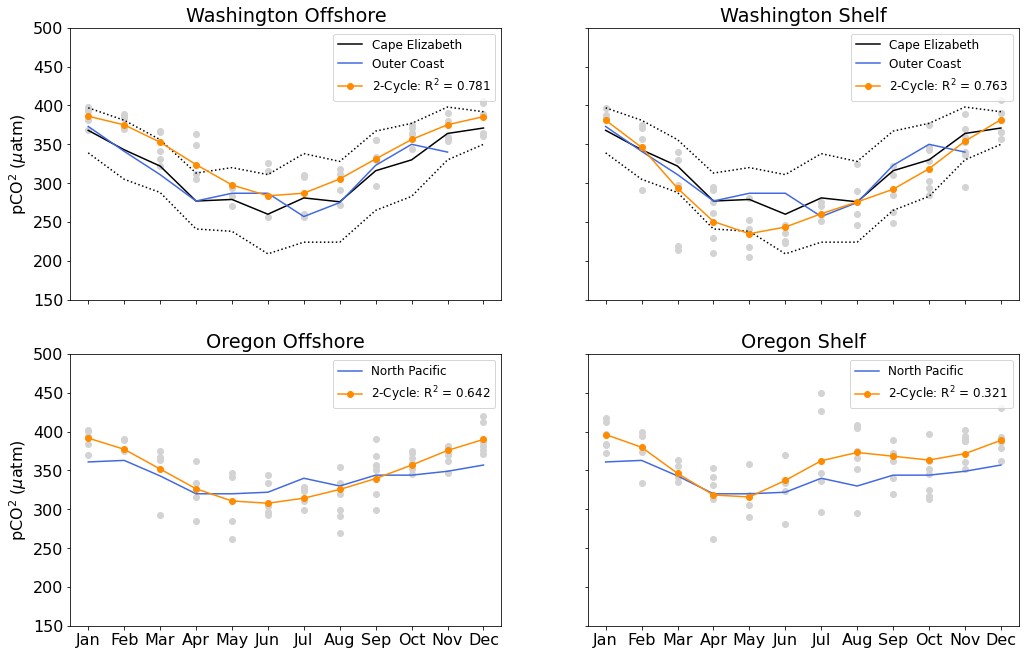

In [18]:
###### Plot the PCO2A data alongside Fassbender et al 2018 ######
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(17, 11)

# calculate the monthly climatologies for the Washington Offshore mooring and group the data monthly 
num = 3
clm.fit(pco2a[num], 'partial_pressure_co2_ssw')
r2 = r'2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_pco2 = pco2a[num].resample(time='M').mean()
grps_pco2 = mnthly_pco2.groupby('time.month')

# Plot the Washington Offshore data
for grp in grps_pco2:
    axs[0, 0].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['partial_pressure_co2_ssw'],
                   'o', color='lightgrey')
axs[0, 0].plot(buoy_fco2[:, 0], buoy_fco2[:, 4], '-k', label='Cape Elizabeth')
axs[0, 0].plot(buoy_fco2[:, 0], buoy_fco2[:, 4] - buoy_fco2[:, 5], ':k', 
               buoy_fco2[:, 0], buoy_fco2[:, 4] + buoy_fco2[:, 5], ':k')
axs[0, 0].plot(region_fco2[:, 0], region_fco2[:, 3], '-', color='royalblue', label='Outer Coast')
axs[0, 0].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[0, 0].legend(prop={'size': 12}, loc=1)
axs[0, 0].set_title('Washington Offshore')

# calculate the monthly climatologies for the Washington Shelf mooring and group the data monthly 
num = 2
clm.fit(pco2a[num], 'partial_pressure_co2_ssw')
r2 = '2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_pco2 = pco2a[num].resample(time='M').mean()
grps_pco2 = mnthly_pco2.groupby('time.month')

# Plot the Washington Shelf data
for grp in grps_pco2:
    axs[0, 1].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['partial_pressure_co2_ssw'],
                   'o', color='lightgrey')
axs[0, 1].plot(buoy_fco2[:, 0], buoy_fco2[:, 4], '-k', label='Cape Elizabeth')
axs[0, 1].plot(buoy_fco2[:, 0], buoy_fco2[:, 4] - buoy_fco2[:, 5], ':k', 
               buoy_fco2[:, 0], buoy_fco2[:, 4] + buoy_fco2[:, 5], ':k')
axs[0, 1].plot(region_fco2[:, 0], region_fco2[:, 3], '-', color='royalblue', label='Outer Coast')
axs[0, 1].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[0, 1].legend(prop={'size': 12}, loc=1)
axs[0, 1].set_title('Washington Shelf')

# calculate the monthly climatologies for the Oregon Offshore mooring and group the data monthly 
num = 1
clm.fit(pco2a[num], 'partial_pressure_co2_ssw')
r2 = '2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_pco2 = pco2a[num].resample(time='M').mean()
grps_pco2 = mnthly_pco2.groupby('time.month')

# Plot the Oregon Offshore data
for grp in grps_pco2:
    axs[1, 0].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['partial_pressure_co2_ssw'],
                   'o', color='lightgrey')
axs[1, 0].plot(region_fco2[:, 0], region_fco2[:, 5], '-', color='royalblue', label=r'North Pacific')
axs[1, 0].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[1, 0].legend(prop={'size': 12}, loc=1)
axs[1, 0].set_title('Oregon Offshore')

# calculate the monthly climatologies for the Oregon Shelf mooring and group the data monthly 
num = 0
clm.fit(pco2a[num], 'partial_pressure_co2_ssw')
r2 = '2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_pco2 = pco2a[num].resample(time='M').mean()
grps_pco2 = mnthly_pco2.groupby('time.month')

# Plot the Oregon Shelf data
for grp in grps_pco2:
    axs[1, 1].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['partial_pressure_co2_ssw'],
                   'o', color='lightgrey')
axs[1, 1].plot(region_fco2[:, 0], region_fco2[:, 5], '-', color='royalblue', label=r'North Pacific')
axs[1, 1].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[1, 1].legend(prop={'size': 12}, loc=1)
axs[1, 1].set_title('Oregon Shelf')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set(ylabel='pCO$^2$ ($\mu$atm)')
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(months)
    ax.set_xlim((0.5, 12.5))
    ax.set_ylim((150, 500))
    
for ax in axs.flat:
    ax.label_outer()
    
plt.show()
fig.savefig(os.path.join('regional_pco2_comparisons.png', dpi=300)

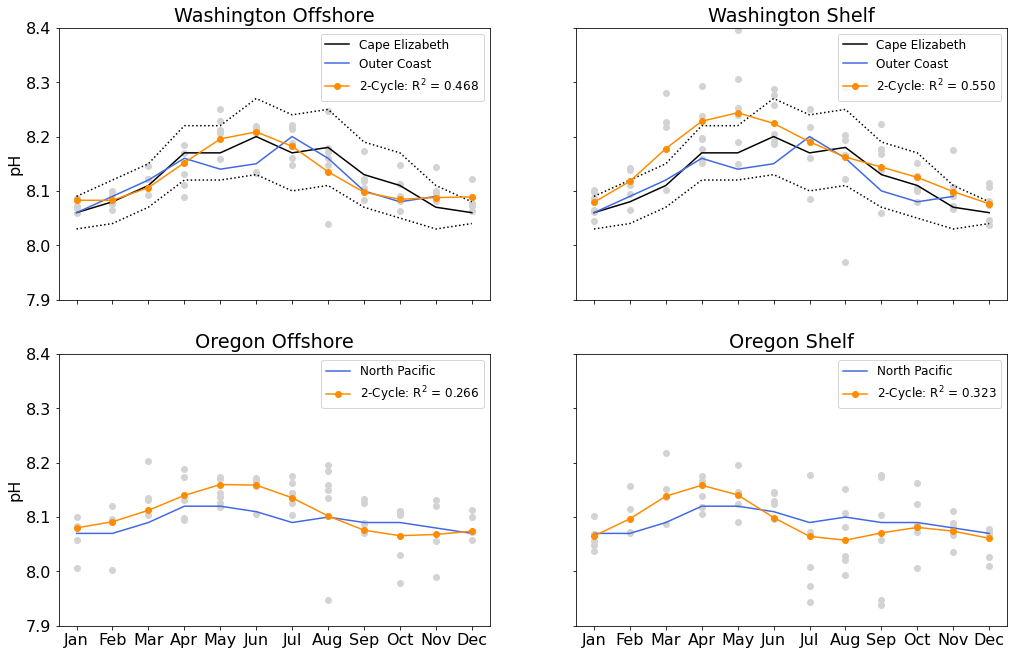

In [19]:
###### Plot the PHSEN data alongside Fassbender et al 2018 ######
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(17, 11)

# calculate the monthly climatologies for the Washington Offshore mooring and group the data monthly 
num = 3
clm.fit(phsen[num], 'seawater_ph')
r2 = r'2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_ph = phsen[num].resample(time='M').mean()
grps_ph = mnthly_ph.groupby('time.month')

# Plot the Washington Offshore data
for grp in grps_ph:
    axs[0, 0].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['seawater_ph'],
                   'o', color='lightgrey')
axs[0, 0].plot(buoy_ph[:, 0], buoy_ph[:, 4], '-k', label='Cape Elizabeth')
axs[0, 0].plot(buoy_ph[:, 0], buoy_ph[:, 4] - buoy_ph[:, 5], ':k', 
               buoy_ph[:, 0], buoy_ph[:, 4] + buoy_ph[:, 5], ':k')
axs[0, 0].plot(region_ph[:, 0], region_ph[:, 3], '-', color='royalblue', label='Outer Coast')
axs[0, 0].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[0, 0].legend(prop={'size': 12}, loc=1)
axs[0, 0].set_title('Washington Offshore')

# calculate the monthly climatologies for the Washington Shelf mooring and group the data monthly 
num = 2
clm.fit(phsen[num], 'seawater_ph')
r2 = '2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_ph = phsen[num].resample(time='M').mean()
grps_ph = mnthly_ph.groupby('time.month')

# Plot the Washington Shelf data
for grp in grps_ph:
    axs[0, 1].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['seawater_ph'],
                   'o', color='lightgrey')
axs[0, 1].plot(buoy_ph[:, 0], buoy_ph[:, 4], '-k', label='Cape Elizabeth')
axs[0, 1].plot(buoy_ph[:, 0], buoy_ph[:, 4] - buoy_ph[:, 5], ':k', 
               buoy_ph[:, 0], buoy_ph[:, 4] + buoy_ph[:, 5], ':k')
axs[0, 1].plot(region_ph[:, 0], region_ph[:, 3], '-', color='royalblue', label='Outer Coast')
axs[0, 1].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[0, 1].legend(prop={'size': 12}, loc=1)
axs[0, 1].set_title('Washington Shelf')

# calculate the monthly climatologies for the Oregon Offshore mooring and group the data monthly 
num = 1
clm.fit(phsen[num], 'seawater_ph')
r2 = '2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_ph = phsen[num].resample(time='M').mean()
grps_ph = mnthly_ph.groupby('time.month')

# Plot the Oregon Offshore data
for grp in grps_ph:
    axs[1, 0].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['seawater_ph'],
                   'o', color='lightgrey')
axs[1, 0].plot(region_ph[:, 0], region_ph[:, 5], '-', color='royalblue', label=r'North Pacific')
axs[1, 0].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[1, 0].legend(prop={'size': 12}, loc=1)
axs[1, 0].set_title('Oregon Offshore')

# calculate the monthly climatologies for the Oregon Shelf mooring and group the data monthly 
num = 0
clm.fit(phsen[num], 'seawater_ph')
r2 = '2-Cycle: R$^2$ = %.3f' % clm.regression['variance_explained'][0]
mnthly_ph = phsen[num].resample(time='M').mean()
grps_ph = mnthly_ph.groupby('time.month')

# Plot the Oregon Shelf data
for grp in grps_ph:
    axs[1, 1].plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['seawater_ph'],
                   'o', color='lightgrey')
axs[1, 1].plot(region_ph[:, 0], region_ph[:, 5], '-', color='royalblue', label=r'North Pacific')
axs[1, 1].plot(clm.monthly_fit.index, clm.monthly_fit.values, '-o', color='darkorange', label=r2)
axs[1, 1].legend(prop={'size': 12}, loc=1)
axs[1, 1].set_title('Oregon Shelf')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set(ylabel='pH')
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(months)
    ax.set_xlim((0.5, 12.5))
    ax.set_ylim((7.9, 8.4))
    
for ax in axs.flat:
    ax.label_outer()
    
plt.show()
fig.savefig('regional_ph_comparisons.png', dpi=300)